In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.precision', 3)

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

path = '/content/drive/MyDrive/dataset/madison'


# Load data with original details (preprocessed)

In [4]:
from typing_extensions import dataclass_transform
data = pd.read_csv(os.path.join(path, 'task3/triplet_update_v3.csv'), encoding='utf-8')
data = data.rename(columns={
            'placetype_subject': 'place_type_subject',
            'placetype_object': 'place_type_object',
            'spatial_relation': 'predicate',
            'relation_predicate': 'description'
        })

data.head()

,place_type_subject,geometry_type_subject,place_type_object,geometry_type_object,Sentence,place_name_subject,place_name_object,vernacular_relation,predicate,description
0,town,MultiPolygon,municipality,Polygon,abuts,"Waupun,wisconsin","town of waupun ,wisconsin",abuts,touches,NaN
1,man_made,Polygon,river,LineString,"""The Rainbow Bridge across the Neches River co...","Rainbow Bridge, Texas",Neches River,across,crosses,NaN
2,town,Polygon,city,MultiPolygon,"""Benicia is just east of Vallejo and across th...","Benicia, California","Martinez, California",across from,touches,is across from
3,city,Polygon,man_made,Polygon,"""Laredo (/l‚Ä¶√¥√Ä√†re‚Ä¶‚Ñ¢do¬†√§/ l‚Ä¶√¥-RAY...","Laredo, Webb County, Texas","Nuevo Laredo, Tamaulipas, Mexico.",across from,touches,is across from
4,city,Polygon,county,Polygon,"""The city limits extend south to the Rio Grand...","McAllen, Texas","Reynosa, Mexico",across from,touches,is across from


In [5]:
data.shape[0], np.sum((data['description'].isin(['is directly direction of', 'is to the south of', 'has some distance from', 'just direction of'])))

(1078, 212)

In [6]:
# remove directional and distance relations
data = data[~(data['description'].isin(['is directly direction of', 'is to the south of', 'has some distance from', 'just direction of']))]

In [7]:
# count descriptions occurs at least 5 times
phrase_cnt = (data['description']
              .value_counts()
              # .sort_values(by='predicate', ascending=False)
              # .reset_index()
)
np.sum(phrase_cnt>=5)

33

In [8]:
# count (description, predicate)
phrase_cnt = (data[['description', 'predicate']]
              .value_counts()
              # .sort_values(by='predicate', ascending=False)
              .reset_index()
)
phrase_cnt.shape

(94, 3)

In [9]:

phrase_cnt.head()

,description,predicate,count
0,is in,within,129
1,is located in,within,71
2,is bordered by,touches,44
3,is surrounded by,touches,36
4,is the county seat of,within,36


In [10]:
phrase_cnt = phrase_cnt[phrase_cnt['count']>=5]
phrase_cnt.shape

(36, 3)

In [11]:
# filter the data
data = data[(data['description'].isin(set(phrase_cnt['description'])))]
data.shape

(750, 10)

In [12]:
# phrase_cnt[['description']].drop_duplicates().to_csv('no_context_result.csv', index=False)

## 1. The categorization of triplets with context

In [13]:

context_cols_dict = {
    'place_type': ['place_type_subject', 'place_type_object'],
    'geometry_type': ['geometry_type_subject', 'geometry_type_object'],
    'place_name': ['place_name_subject', 'place_name_object']
}

In [14]:
data['context_comb_1_to_1'] = 'N/A'
data['context_comb_place_type'] = data['place_type_subject'] + '/' + data['place_type_object']
data['context_comb_geometry_type'] = data['geometry_type_subject'] + '/' + data['geometry_type_object']

data['context_comb_place_name'] =   data['place_name_subject'] + '/' + data['place_name_object']

In [15]:
context_types = ['1_to_1',  'place_type',  'geometry_type', 'place_name'] #list(context_cols_dict.keys())
context_types

['1_to_1', 'place_type', 'geometry_type', 'place_name']

In [16]:
# obtain context-conditioned conversion pairs
i = 0
for context_type in context_types:
    df_cnt = (data[['description', 'predicate']+['context_comb'+'_'+context_type]]
              .rename(columns={'context_comb'+'_'+context_type: 'context_comb'})
              .groupby(['description', 'context_comb'])
              .value_counts()
              .reset_index()
    )
    df_cnt['context'] = context_type
    df_cnt['rank'] = i
    if i==0:
        context_cnt_df = df_cnt.copy()
    else:
        context_cnt_df = pd.concat([context_cnt_df, df_cnt], axis=0)
    i += 1

context_cnt_df = pd.merge(context_cnt_df,
                      context_cnt_df[['description', 'context_comb', 'count']].groupby(['description', 'context_comb']).sum().reset_index(),
                      on=['description', 'context_comb'], how='left')
context_cnt_df = context_cnt_df
context_cnt_df.sort_values(by=['description', 'context', 'context_comb'])

,description,context_comb,predicate,count_x,context,rank,count_y
0,borders,N/A,touches,32,1_to_1,0,35
1,borders,N/A,overlaps,3,1_to_1,0,35
309,borders,MultiPolygon/MultiPolygon,touches,2,geometry_type,2,2
310,borders,MultiPolygon/Polygon,touches,1,geometry_type,2,1
311,borders,Polygon/LineString,touches,1,geometry_type,2,1
...,...,...,...,...,...,...,...
304,share border with,city/county,touches,2,place_type,1,2
305,share border with,city/town,touches,1,place_type,1,1
306,share border with,town/census,touches,3,place_type,1,3
307,share border with,town/city,touches,1,place_type,1,1


In [17]:
(context_cnt_df #[(context_cnt_df['count_x']==context_cnt_df['count_y'])]
 .sort_values(by=['description', 'predicate', 'rank'], ascending=[True,  True, True])
 .drop_duplicates(subset=['description', 'predicate'])).shape

(73, 7)

In [18]:
context_df = (context_cnt_df #[(context_cnt_df['count_x']==context_cnt_df['count_y'])]
 .sort_values(by=['description', 'rank', 'predicate'], ascending=[True,  True, True]))

context_df

,description,context_comb,predicate,count_x,context,rank,count_y
1,borders,N/A,overlaps,3,1_to_1,0,35
0,borders,N/A,touches,32,1_to_1,0,35
75,borders,city/hamlet,overlaps,1,place_type,1,1
76,borders,city/man_made,overlaps,1,place_type,1,1
85,borders,water/country,overlaps,1,place_type,1,1
...,...,...,...,...,...,...,...
1211,share border with,"Walnut Creek, California/Alamo, California",touches,1,place_name,3,1
1212,share border with,"Walnut Creek, California/Clayton, California",touches,1,place_name,3,1
1213,share border with,"Walnut Creek, California/Concord,california",touches,1,place_name,3,1
1214,share border with,"Walnut Creek, California/Lafayette, California",touches,1,place_name,3,1


In [19]:
context_df[(context_df['description']=='is bordered by') & (context_df['context']=='place_name')]

,description,context_comb,predicate,count_x,context,rank,count_y
634,is bordered by,"Beaumont, California/San Jacinto, California",disjoint,1,place_name,3,1
645,is bordered by,"Huntington Park, California/Commerce, California",disjoint,1,place_name,3,1
651,is bordered by,"Maywood, California/Commerce, California",disjoint,1,place_name,3,1
658,is bordered by,"Newport Beach, California/Huntington Beach, Ca...",disjoint,1,place_name,3,1
678,is bordered by,"the Pacific Ocean, California/Huntington Beach...",disjoint,1,place_name,3,1
633,is bordered by,"Beaumont, California/Cherry Valley, California",overlaps,1,place_name,3,1
638,is bordered by,"Covina, California/West Covina, California",overlaps,1,place_name,3,1
627,is bordered by,"Aliso Viejo, California/Laguna Beach, California",touches,1,place_name,3,1
628,is bordered by,"Aliso Viejo, California/Laguna Hills, California",touches,1,place_name,3,1
629,is bordered by,"Aliso Viejo, California/Laguna Niguel, California",touches,1,place_name,3,1


In [20]:
(context_cnt_df[(context_cnt_df['count_x']==context_cnt_df['count_y'])] # one-to-one if count_x = count_y
 .sort_values(by=['description', 'predicate', 'count_x'], ascending=[True,  True, False])
 .drop_duplicates(subset='description')
 .sort_values(by='rank')
 [['description', 'rank', 'predicate', 'context', 'context_comb', 'count_x', 'count_y']])

,description,rank,predicate,context,context_comb,count_x,count_y
72,share border with,0,touches,1_to_1,N/A,13,13
66,is the location of,0,contains,1_to_1,N/A,11,11
6,has part of the population in,0,overlaps,1_to_1,N/A,19,19
17,is an enclave of,0,touches,1_to_1,N/A,10,10
27,is halfway between C and,0,disjoint,1_to_1,N/A,10,10
39,is midway between C and,0,disjoint,1_to_1,N/A,5,5
291,is within,1,overlaps,place_type,city/county,2,2
258,is suburb of,1,disjoint,place_type,city/aeroway,1,1
246,is partly in,1,overlaps,place_type,city/county,5,5
237,is part of,1,disjoint,place_type,city/aeroway,1,1


In [21]:
df = (context_cnt_df[(context_cnt_df['count_x']>=5)&(context_cnt_df['count_x']==context_cnt_df['count_y'])]
 .sort_values(by=['description', 'predicate', 'rank'], ascending=[True,  True, True])
#  .drop_duplicates(subset='description')
 .sort_values(by='rank')
 [['description', 'rank', 'predicate', 'context', 'context_comb', 'count_x', 'count_y']])
df.shape

(40, 7)

In [22]:
df_1_to_1 = df[df['context']=='1_to_1']

In [23]:
df = pd.concat([df[~(df['description'].isin(set(df_1_to_1['description'])))],
                df_1_to_1], axis=0).sort_index() # remove context-invariant conversion pairs
df.shape

(30, 7)

In [24]:
df['count_x'].sum()

280

In [25]:
ct = 'geometry_type'

np.sum(df['context']==ct), df[['description', 'predicate']][df['context']==ct].drop_duplicates().shape[0], df['count_x'][df['context']==ct].sum()

(7, 7, 67)

In [26]:
(df[['description', 'predicate', 'context']][(df['context']=='geometry_type')|(df['context']=='place_type')]
 .drop_duplicates()
 .groupby(['description', 'predicate'])
 .count())

,,context
description,predicate,
borders,touches,1
connect C and,crosses,2
extend into,overlaps,2
is adjacent to,touches,1
is between C and,touches,1
is bordered by,touches,2
is bounded by,touches,1
is home to,contains,1
is in,within,2


In [27]:
# df.to_csv('context_result_cnt5.csv', index=False)

In [28]:
df_name = context_cnt_df[(context_cnt_df['context']=='place_name')][['description', 'predicate', 'context', 'context_comb', 'count_x', 'count_y']]
df_name = pd.merge(df_name, phrase_cnt[['description', 'predicate']], on=['description', 'predicate'], how='inner')
df_name = df_name.sample(frac=1, random_state=0).sort_values(by=['description', 'predicate']).reset_index(drop=True)
df_name['idx'] = df_name.index
df_name_first = df_name.drop_duplicates(subset=['description', 'predicate'])
df_name = pd.merge(df_name, df_name_first[['description', 'predicate', 'idx']], on=['description', 'predicate'], how='inner')
df_name = df_name[df_name['idx_x']<df_name['idx_y']+5]
df_name = df_name[['description', 'predicate', 'context', 'context_comb', 'count_x', 'count_y']]
df_name = df_name[~(df_name['description'].isin(set(df_1_to_1['description'])))]
# df_name = pd.merge(df_name, df[['description', 'predicate', 'context']], on=['description', 'predicate'], how='left')
# df_name = df_name[pd.isnull(df_name['rank'])]
# df_name.sample(frac=1, random_state=0).drop_duplicates(subset=['description', 'predicate'])

df_name.shape

(150, 6)

In [29]:
df_name[['description', 'predicate']].value_counts()

description            predicate
borders                touches      5
connect C and          crosses      5
is within              touches      5
is the county seat of  within       5
is surrounded by       touches      5
is suburb of           touches      5
                       disjoint     5
is situated on         overlaps     5
is partly in           touches      5
                       overlaps     5
is part of             within       5
is on                  crosses      5
is neighboring         touches      5
is near                touches      5
                       disjoint     5
is mostly in           overlaps     5
is located in          within       5
is in                  within       5
                       overlaps     5
is home to             contains     5
is bounded by          touches      5
is bordered by         touches      5
                       disjoint     5
is between C and       touches      5
                       disjoint     5
is along               crosses      5
is adjacent to         touches      5
includes               contains     5
extend into            overlaps     5
on the shore of        overlaps     5
Name: count, dtype: int64

In [30]:
# df_name.to_csv('name_result_cnt5.csv', index=False)

# Load results

In [31]:
result = pd.read_csv(os.path.join(path, 'task3/context_result_cnt5.csv')) # paste the results to the table

result = result.rename(columns={'relation_predicate': 'description'})
result = pd.merge(result, phrase_cnt[['description', 'predicate']],
                  on=['description', 'predicate'], how='inner')
result['index'] = np.arange(result.shape[0])
result.head()

,description,rank,predicate,context,context_comb,count_x,count_y,contains,within,overlaps,touches,disjoint,equals,crosses,index
0,is the location of,0,contains,1_to_1,NaN,11,11,9,0,0,0,0,2,0,0
1,has part of the population in,0,overlaps,1_to_1,NaN,19,19,6,1,10,0,0,0,0,1
2,is an enclave of,0,touches,1_to_1,NaN,10,10,0,9,0,1,0,0,0,2
3,is midway between C and,0,disjoint,1_to_1,NaN,5,5,0,2,0,1,6,0,1,3
4,is halfway between C and,0,disjoint,1_to_1,NaN,10,10,1,1,1,1,6,1,1,4


In [32]:
# descriptions without context provided for compairson
result_without_context = pd.read_csv(os.path.join(path, 'task3/no_context_result.csv'))
result_without_context


,relation_predicate,contains,within,overlaps,touches,disjoint,equals,crosses
0,share border with,0,0,0,10,0,0,0
1,on the shore of,0,0,0,10,0,0,0
2,is along,0,1,0,10,0,0,5
3,is the county seat of,0,10,0,0,0,0,0
4,is mostly in,0,4,10,0,0,0,0
5,is within,0,10,0,0,0,0,0
6,is halfway between C and,0,1,0,0,7,0,0
7,includes,10,0,0,0,0,0,0
8,is midway between C and,0,0,0,2,3,0,0
9,extend into,0,0,8,2,0,0,9


In [33]:

result_without_context = result_without_context.rename(columns={'relation_predicate': 'description'})
result_without_context = pd.merge(result[['description', 'context', 'context_comb', 'predicate', 'index']][result['context']!='1_to_1'],
                               result_without_context, on='description', how='left')
result_without_context

,description,context,context_comb,predicate,index,contains,within,overlaps,touches,disjoint,equals,crosses
0,borders,place_type,city/city,touches,6,0,0,0,10,0,0,0
1,borders,place_type,city/municipality,touches,7,0,0,0,10,0,0,0
2,connect C and,place_type,industrial/city,crosses,8,0,0,0,10,0,0,9
3,extend into,place_type,city/county,overlaps,9,0,0,8,2,0,0,9
4,is adjacent to,place_type,city/municipality,touches,10,0,0,0,10,1,0,0
5,is between C and,place_type,town/town,touches,11,0,1,1,3,3,0,2
6,is bordered by,place_type,town/city,touches,12,0,0,0,10,0,0,0
7,is bounded by,place_type,city/city,touches,13,0,10,0,5,0,0,0
8,is home to,place_type,city/amenity,contains,14,10,0,0,0,0,0,0
9,is in,place_type,village/county,within,15,0,10,0,0,0,1,0


In [34]:
predicate_cols = result_without_context.columns[5:]
predicate_cols

Index(['contains', 'within', 'overlaps', 'touches', 'disjoint', 'equals',
       'crosses'],
      dtype='object')

# Accuracy

In [35]:
def compute_accuracy(df):
    predicate = df['predicate'].iloc[0]
    print(predicate)
    acc = df[predicate] / df[predicate_cols].sum(axis=1)

    return pd.DataFrame({
        'description': df['description'],
        'predicate': df['predicate'],
        'context': df['context'],
        'context_comb': df['context_comb'],
        'frequency': df[predicate],
        'accuracy': acc,
        'index': df['index']})

In [36]:

acc = result.groupby('predicate', as_index=False).apply(compute_accuracy)
acc

contains
crosses
disjoint
overlaps
touches
within


<ipython-input-36-cd33c73992df>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc = result.groupby('predicate', as_index=False).apply(compute_accuracy)


description predicate        context  \
0 0              is the location of  contains         1_to_1   
  14                     is home to  contains     place_type   
1 8                   connect C and   crosses     place_type   
  23                  connect C and   crosses  geometry_type   
  28                          is on   crosses  geometry_type   
2 3         is midway between C and  disjoint         1_to_1   
  4        is halfway between C and  disjoint         1_to_1   
3 1   has part of the population in  overlaps         1_to_1   
  9                     extend into  overlaps     place_type   
  19                   is partly in  overlaps     place_type   
  24                    extend into  overlaps  geometry_type   
4 2                is an enclave of   touches         1_to_1   
  5               share border with   touches         1_to_1   
  6                         borders   touches     place_type   
  7                         borders   touches     place_type   
  10                 is adjacent to   touches     place_type   
  11               is between C and   touches     place_type   
  12                 is bordered by   touches     place_type   
  13                  is bounded by   touches     place_type   
  20               is surrounded by   touches     place_type   
  21               is surrounded by   touches     place_type   
  22                      is within   touches     place_type   
  25                 is bordered by   touches  geometry_type   
  27                 is neighboring   touches  geometry_type   
  29               is surrounded by   touches  geometry_type   
5 15                          is in    within     place_type   
  16                  is located in    within     place_type   
  17                  is located in    within     place_type   
  18                  is located in    within     place_type   
  26                          is in    within  geometry_type   
  30          is the county seat of    within  geometry_type   

                 context_comb  frequency  accuracy  index  
0 0                       NaN          9     0.818      0  
  14             city/amenity         10     1.000     14  
1 8           industrial/city          8     0.400      8  
  23  LineString/MultiPolygon          7     0.412     23  
  28       Polygon/LineString          0     0.000     28  
2 3                       NaN          6     0.600      3  
  4                       NaN          6     0.500      4  
3 1                       NaN         10     0.588      1  
  9               city/county          5     0.357      9  
  19              city/county         10     0.833     19  
  24          Polygon/Polygon         10     0.714     24  
4 2                       NaN          1     0.100      2  
  5                       NaN         10     1.000      5  
  6                 city/city         10     1.000      6  
  7         city/municipality         10     1.000      7  
  10        city/municipality         10     1.000     10  
  11                town/town          0     0.000     11  
  12                town/city         10     1.000     12  
  13                city/city          7     0.700     13  
  20                city/city          2     0.167     20  
  21                town/city          0     0.000     21  
  22        city/municipality          0     0.000     22  
  25     Polygon/MultiPolygon         10     1.000     25  
  27          Polygon/Polygon         10     1.000     27  
  29     Polygon/MultiPolygon          0     0.000     29  
5 15           village/county         10     0.909     15  
  16               city/state         10     1.000     16  
  17              town/county         10     1.000     17  
  18           village/county         10     0.909     18  
  26     Polygon/MultiPolygon         10     1.000     26  
  30          Polygon/Polygon         10     1.000     30

In [37]:
acc_1_to_1 = acc[acc['context']=='1_to_1']
acc_1_to_1['accuracy'].mean()

0.6010695187165775

In [38]:
acc_without_context = result_without_context.groupby('predicate', as_index=False).apply(compute_accuracy)
acc_without_context = pd.concat([acc_without_context, acc_1_to_1], axis=0)
acc_without_context

contains
crosses
overlaps
touches
within


<ipython-input-38-dfff1bc6cbf6>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_without_context = result_without_context.groupby('predicate', as_index=False).apply(compute_accuracy)


description predicate        context  \
0 8                      is home to  contains     place_type   
1 2                   connect C and   crosses     place_type   
  17                  connect C and   crosses  geometry_type   
  22                          is on   crosses  geometry_type   
2 3                     extend into  overlaps     place_type   
  13                   is partly in  overlaps     place_type   
  18                    extend into  overlaps  geometry_type   
3 0                         borders   touches     place_type   
  1                         borders   touches     place_type   
  4                  is adjacent to   touches     place_type   
  5                is between C and   touches     place_type   
  6                  is bordered by   touches     place_type   
  7                   is bounded by   touches     place_type   
  14               is surrounded by   touches     place_type   
  15               is surrounded by   touches     place_type   
  16                      is within   touches     place_type   
  19                 is bordered by   touches  geometry_type   
  21                 is neighboring   touches  geometry_type   
  23               is surrounded by   touches  geometry_type   
4 9                           is in    within     place_type   
  10                  is located in    within     place_type   
  11                  is located in    within     place_type   
  12                  is located in    within     place_type   
  20                          is in    within  geometry_type   
  24          is the county seat of    within  geometry_type   
0 0              is the location of  contains         1_to_1   
2 3         is midway between C and  disjoint         1_to_1   
  4        is halfway between C and  disjoint         1_to_1   
3 1   has part of the population in  overlaps         1_to_1   
4 2                is an enclave of   touches         1_to_1   
  5               share border with   touches         1_to_1   

                 context_comb  frequency  accuracy  index  
0 8              city/amenity         10     1.000     14  
1 2           industrial/city          9     0.474      8  
  17  LineString/MultiPolygon          9     0.474     23  
  22       Polygon/LineString          0     0.000     28  
2 3               city/county          8     0.421      9  
  13              city/county         10     1.000     19  
  18          Polygon/Polygon          8     0.421     24  
3 0                 city/city         10     1.000      6  
  1         city/municipality         10     1.000      7  
  4         city/municipality         10     0.909     10  
  5                 town/town          3     0.300     11  
  6                 town/city         10     1.000     12  
  7                 city/city          5     0.333     13  
  14                city/city          0     0.000     20  
  15                town/city          0     0.000     21  
  16        city/municipality          0     0.000     22  
  19     Polygon/MultiPolygon         10     1.000     25  
  21          Polygon/Polygon         10     1.000     27  
  23     Polygon/MultiPolygon          0     0.000     29  
4 9            village/county         10     0.909     15  
  10               city/state         10     1.000     16  
  11              town/county         10     1.000     17  
  12           village/county         10     1.000     18  
  20     Polygon/MultiPolygon         10     0.909     26  
  24          Polygon/Polygon         10     1.000     30  
0 0                       NaN          9     0.818      0  
2 3                       NaN          6     0.600      3  
  4                       NaN          6     0.500      4  
3 1                       NaN         10     0.588      1  
4 2                       NaN          1     0.100      2  
  5                       NaN         10     1.000      5

In [39]:
acc = pd.merge(acc, acc_without_context[['index', 'frequency', 'accuracy']].rename(columns={
    'frequency': 'frequency_no_context',
    'accuracy': 'accuracy_no_context'}),
              on='index', how='left')
acc['frequency_increase'] = acc['frequency'] - acc['frequency_no_context']
acc['accuracy_improve'] = acc['accuracy'] - acc['accuracy_no_context']

In [40]:
acc[['accuracy', 'accuracy_improve', 'context']].groupby('context').mean()

,accuracy,accuracy_improve
context,,
1_to_1,0.601,0.000
geometry_type,0.641,0.040
place_type,0.663,-0.004


In [41]:
acc[['accuracy', 'accuracy_improve', 'context', 'predicate']].groupby(['context', 'predicate']).mean()

accuracy  accuracy_improve
context       predicate                            
1_to_1        contains      0.818             0.000
              disjoint      0.550             0.000
              overlaps      0.588             0.000
              touches       0.550             0.000
geometry_type crosses       0.206            -0.031
              overlaps      0.714             0.293
              touches       0.667             0.000
              within        1.000             0.045
place_type    contains      1.000             0.000
              crosses       0.400            -0.074
              overlaps      0.595            -0.115
              touches       0.541             0.036
              within        0.955            -0.023

# Entropy

In [42]:
def compute_entropy(df):
    p = df[predicate_cols].values / df[predicate_cols].sum(axis=1).values.reshape(-1,1)


    return pd.DataFrame({
        'description': df['description'],
        'predicate': df['predicate'],
        'context': df['context'],
        'context_comb': df['context_comb'],
                      'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),
                        'index': df['index']})

In [43]:

entropy = compute_entropy(result)
entropy

<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: divide by zero encountered in log2
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),
<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: invalid value encountered in multiply
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),


,description,predicate,context,context_comb,entropy,index
0,is the location of,contains,1_to_1,NaN,0.244,0
1,has part of the population in,overlaps,1_to_1,NaN,0.435,1
2,is an enclave of,touches,1_to_1,NaN,0.167,2
3,is midway between C and,disjoint,1_to_1,NaN,0.560,3
4,is halfway between C and,disjoint,1_to_1,NaN,0.817,4
5,share border with,touches,1_to_1,NaN,0.000,5
6,borders,touches,place_type,city/city,0.000,6
7,borders,touches,place_type,city/municipality,0.000,7
8,connect C and,crosses,place_type,industrial/city,0.520,8
9,extend into,overlaps,place_type,city/county,0.561,9


In [44]:
entropy_1_to_1 = entropy[entropy['context']=='1_to_1']
entropy_1_to_1['entropy'].mean()

0.3703078658499656

In [45]:
entropy_1_to_1['entropy'][entropy_1_to_1['entropy']>0].mean()

0.44436943901995873

In [46]:
entropy_without_context = compute_entropy(result_without_context)
entropy_without_context = pd.concat([entropy_without_context, entropy_1_to_1], axis=0)
entropy_without_context

<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: divide by zero encountered in log2
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),
<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: invalid value encountered in multiply
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),


,description,predicate,context,context_comb,entropy,index
0,borders,touches,place_type,city/city,0.000,6
1,borders,touches,place_type,city/municipality,0.000,7
2,connect C and,crosses,place_type,industrial/city,0.355,8
3,extend into,overlaps,place_type,city/county,0.491,9
4,is adjacent to,touches,place_type,city/municipality,0.157,10
5,is between C and,touches,place_type,town/town,0.773,11
6,is bordered by,touches,place_type,town/city,0.000,12
7,is bounded by,touches,place_type,city/city,0.327,13
8,is home to,contains,place_type,city/amenity,0.000,14
9,is in,within,place_type,village/county,0.157,15


In [47]:
entropy = pd.merge(entropy, entropy_without_context[['index', 'entropy']].rename(columns={'entropy': 'entropy_no_context'}),
              on='index', how='left')
entropy['entropy_drop'] =  entropy['entropy_no_context'] - entropy['entropy']

In [48]:
entropy[['entropy', 'entropy_drop', 'context']].groupby('context').mean()

,entropy,entropy_drop
context,,
1_to_1,0.370,0.000
geometry_type,0.082,0.084
place_type,0.140,-0.007


In [49]:
entropy[['entropy', 'entropy_drop', 'context', 'predicate']].groupby(['context', 'predicate']).mean()

entropy  entropy_drop
context       predicate                       
1_to_1        contains     0.244         0.000
              disjoint     0.688         0.000
              overlaps     0.435         0.000
              touches      0.084         0.000
geometry_type crosses      0.174         0.167
              overlaps     0.307         0.183
              touches      0.000         0.000
              within       0.000         0.078
place_type    contains     0.000         0.000
              crosses      0.520        -0.165
              overlaps     0.396        -0.151
              touches      0.084         0.056
              within       0.078        -0.039

## 1 on 1

In [50]:
metric_1_to_1 = pd.merge(acc_1_to_1, entropy_1_to_1[['index', 'entropy']], on='index', how='left')
metric_1_to_1.sort_values(by='frequency', ascending=False)

,description,predicate,context,context_comb,frequency,accuracy,index,entropy
3,has part of the population in,overlaps,1_to_1,NaN,10,0.588,1,0.435
5,share border with,touches,1_to_1,NaN,10,1.000,5,0.000
0,is the location of,contains,1_to_1,NaN,9,0.818,0,0.244
1,is midway between C and,disjoint,1_to_1,NaN,6,0.600,3,0.560
2,is halfway between C and,disjoint,1_to_1,NaN,6,0.500,4,0.817
4,is an enclave of,touches,1_to_1,NaN,1,0.100,2,0.167


In [51]:
metric_1_to_1 = pd.merge(result[result['context']=='1_to_1'], metric_1_to_1[['index', 'frequency', 'accuracy', 'entropy']], on='index', how='left')
metric_1_to_1


,description,rank,predicate,context,context_comb,count_x,count_y,contains,within,overlaps,touches,disjoint,equals,crosses,index,frequency,accuracy,entropy
0,is the location of,0,contains,1_to_1,NaN,11,11,9,0,0,0,0,2,0,0,9,0.818,0.244
1,has part of the population in,0,overlaps,1_to_1,NaN,19,19,6,1,10,0,0,0,0,1,10,0.588,0.435
2,is an enclave of,0,touches,1_to_1,NaN,10,10,0,9,0,1,0,0,0,2,1,0.100,0.167
3,is midway between C and,0,disjoint,1_to_1,NaN,5,5,0,2,0,1,6,0,1,3,6,0.600,0.560
4,is halfway between C and,0,disjoint,1_to_1,NaN,10,10,1,1,1,1,6,1,1,4,6,0.500,0.817
5,share border with,0,touches,1_to_1,NaN,13,13,0,0,0,10,0,0,0,5,10,1.000,0.000


## Place types or geometry types

In [52]:
metric_types = pd.merge(acc[acc['context'].isin(['place_type', 'geometry_type'])],
                  entropy[entropy['context'].isin(['place_type', 'geometry_type'])][['index', 'entropy', 'entropy_no_context', 'entropy_drop']],
                  on='index', how='left').sort_values(by='accuracy', ascending=False)
metric_types['pair'] = metric_types['description'] + '->' + metric_types['predicate'] + '\n(' + metric_types['context_comb'] + ')'
metric_types

,description,predicate,context,context_comb,frequency,accuracy,index,frequency_no_context,accuracy_no_context,frequency_increase,accuracy_improve,entropy,entropy_no_context,entropy_drop,pair
0,is home to,contains,place_type,city/amenity,10,1.000,14,10,1.000,0,0.000,0.000,0.000,0.000,is home to->contains\n(city/amenity)
9,is adjacent to,touches,place_type,city/municipality,10,1.000,10,10,0.909,0,0.091,0.000,0.157,0.157,is adjacent to->touches\n(city/municipality)
23,is in,within,geometry_type,Polygon/MultiPolygon,10,1.000,26,10,0.909,0,0.091,0.000,0.157,0.157,is in->within\n(Polygon/MultiPolygon)
21,is located in,within,place_type,town/county,10,1.000,17,10,1.000,0,0.000,0.000,0.000,0.000,is located in->within\n(town/county)
20,is located in,within,place_type,city/state,10,1.000,16,10,1.000,0,0.000,0.000,0.000,0.000,is located in->within\n(city/state)
17,is neighboring,touches,geometry_type,Polygon/Polygon,10,1.000,27,10,1.000,0,0.000,0.000,0.000,0.000,is neighboring->touches\n(Polygon/Polygon)
16,is bordered by,touches,geometry_type,Polygon/MultiPolygon,10,1.000,25,10,1.000,0,0.000,0.000,0.000,0.000,is bordered by->touches\n(Polygon/MultiPolygon)
11,is bordered by,touches,place_type,town/city,10,1.000,12,10,1.000,0,0.000,0.000,0.000,0.000,is bordered by->touches\n(town/city)
24,is the county seat of,within,geometry_type,Polygon/Polygon,10,1.000,30,10,1.000,0,0.000,0.000,0.000,0.000,is the county seat of->within\n(Polygon/Polygon)
8,borders,touches,place_type,city/municipality,10,1.000,7,10,1.000,0,0.000,0.000,0.000,0.000,borders->touches\n(city/municipality)


In [53]:
metric_types[['context', 'accuracy', 'accuracy_improve', 'entropy', 'entropy_drop']].groupby('context').mean()

,accuracy,accuracy_improve,entropy,entropy_drop
context,,,,
geometry_type,0.641,0.040,0.082,0.084
place_type,0.663,-0.004,0.140,-0.007


In [54]:

plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})

Text(0.5, 0.92, 'Place types as context')

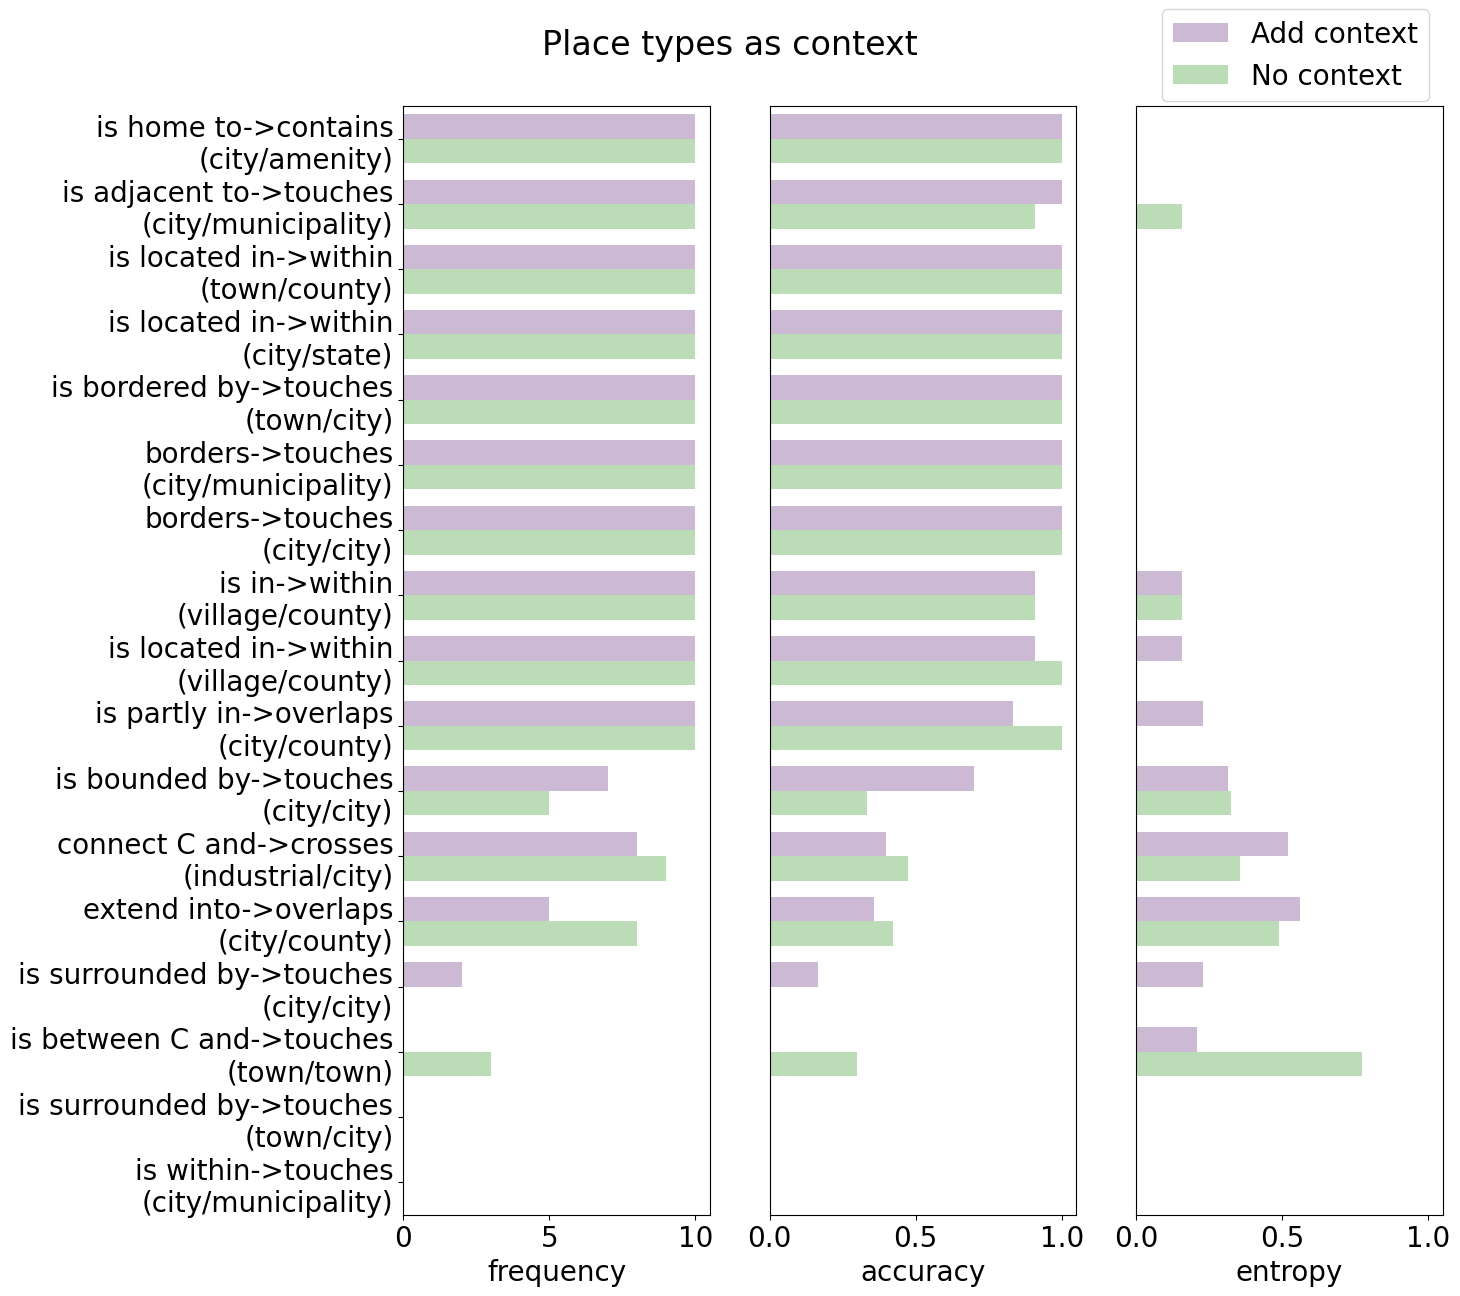

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(15,14), tight_layout=True)
# plt.rcParams.update({'font.size': 20})
# plt.rcParams.update({'xtick.labelsize': 20})
# plt.rcParams.update({'ytick.labelsize': 20})

context = 'place_type'
metrics = ['frequency', 'accuracy', 'entropy']
for j in range(3):
    metric = metrics[j]
    df = metric_types[(metric_types['context']==context)][['pair', metric]].copy()
    df['class'] = 'Add context'
    df1 = metric_types[(metric_types['context']==context)][['pair', metric+'_no_context']].rename(columns={metric+'_no_context': metric}).copy()
    df1['class'] = 'No context'
    sns.barplot(data=pd.concat([df, df1]), y='pair', x=metric, orient='y',
                hue='class', ax=ax[j], width=.75, palette = "PRGn", )
    if j>0:
      ax[j].set_xlim([0, 1.05])

ax[0].get_legend().remove()
ax[0].set_xlabel('frequency')
ax[0].set_ylabel('')

ax[1].get_legend().remove()
ax[1].set_xlabel('accuracy')
ax[1].set_ylabel('')
ax[1].get_yaxis().set_ticks([])

# ax[1].get_xaxis().set_ticks([])
ax[2].set_xlabel('entropy')
ax[2].set_ylabel('')
ax[2].get_yaxis().set_ticks([])
ax[2].legend(loc='upper right', bbox_to_anchor=(0.5, 0.6, 0.5, 0.5))#loc='lower right'

fig.suptitle('Place types as context', x=0.5, y=0.92)
# plt.savefig(path+'/result/task3/barplot_place.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.83, 'Geometry types as context')

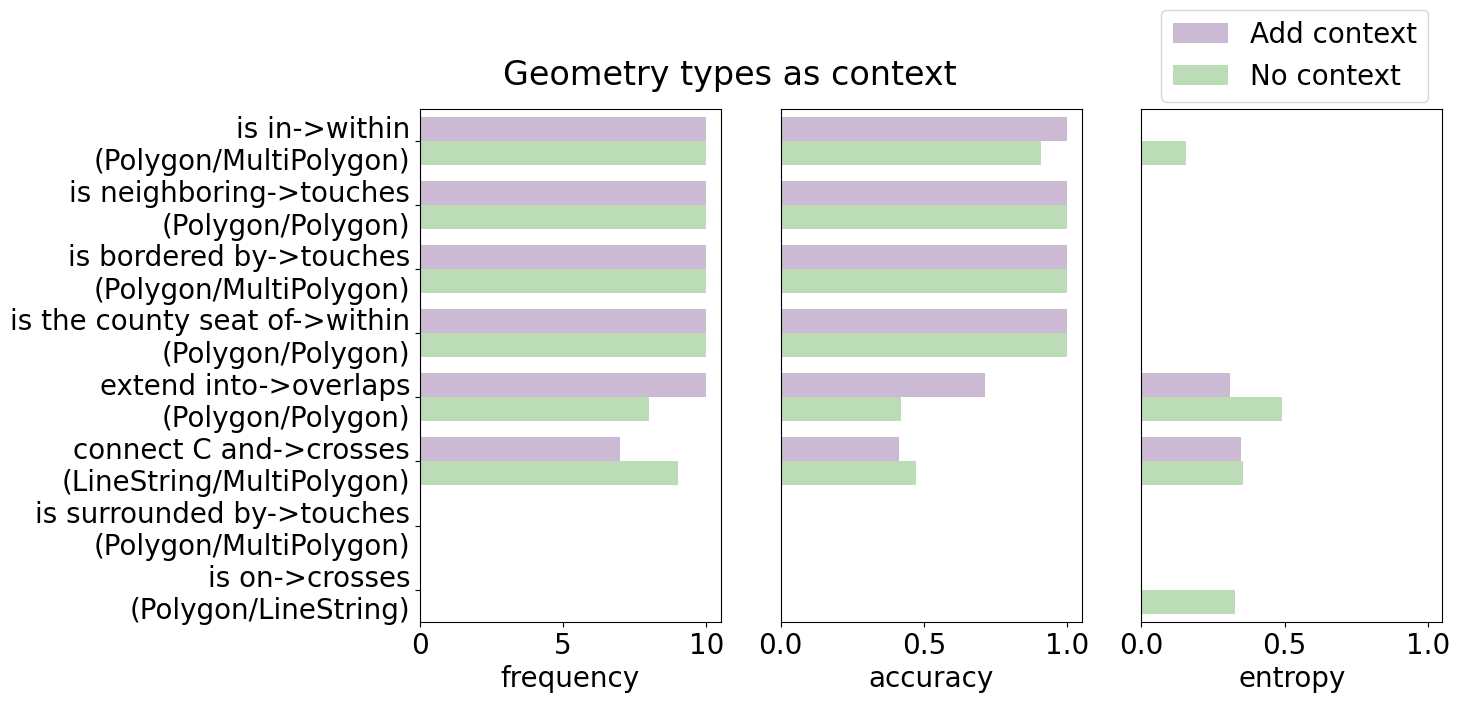

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(15,8), tight_layout=True)
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})

context = 'geometry_type'
metrics = ['frequency', 'accuracy', 'entropy']
for j in range(3):
    metric = metrics[j]
    df = metric_types[(metric_types['context']==context)][['pair', metric]].copy()
    df['class'] = 'Add context'
    df1 = metric_types[(metric_types['context']==context)][['pair', metric+'_no_context']].rename(columns={metric+'_no_context': metric}).copy()
    df1['class'] = 'No context'
    sns.barplot(data=pd.concat([df, df1]), y='pair', x=metric, orient='y',
                hue='class', ax=ax[j], width=.75, palette = "PRGn", )
    if j>0:
      ax[j].set_xlim([0, 1.05])

ax[0].get_legend().remove()
ax[0].set_xlabel('frequency')
ax[0].set_ylabel('')

ax[1].get_legend().remove()
ax[1].set_xlabel('accuracy')
ax[1].set_ylabel('')
ax[1].get_yaxis().set_ticks([])

# ax[1].get_xaxis().set_ticks([])
ax[2].set_xlabel('entropy')
ax[2].set_ylabel('')
ax[2].get_yaxis().set_ticks([])
ax[2].legend(loc='upper right', bbox_to_anchor=(0.5, 0.72, 0.5, 0.5))#loc='lower right'

fig.suptitle('Geometry types as context', x=0.5, y=0.83)
# plt.savefig(path+'/result/task3/barplot_geometry.png', dpi=300, bbox_inches='tight')

## Place name

In [57]:
result_name = pd.read_csv(os.path.join(path, 'task3/name_result_cnt5.csv'))
result_name = result_name.rename(columns={'relation_predicate': 'description'})
result_name = pd.merge(result_name, phrase_cnt[['description', 'predicate']], on=['description', 'predicate'], how='inner')
result_name['index'] = np.arange(result_name.shape[0])
result_name = result_name[~(result_name['description'].isin(set(df_1_to_1['description'])))]
result_name

,description,predicate,context,context_comb,count_x,count_y,contains,within,overlaps,touches,disjoint,equals,crosses,index
0,borders,touches,place_name,"Universal City, Texas/San Antonio, Texas",1,1,0,0,0,3,0,0,0,0
1,borders,touches,place_name,"Laguna Niguel, California/Laguna Hills, Califo...",1,1,0,0,0,3,0,0,0,1
2,borders,touches,place_name,"Berkeley, California/Oakland, California",1,1,0,0,0,3,0,0,0,2
3,borders,touches,place_name,"San Mateo, California/Burlingame, California",1,1,0,0,0,3,0,0,0,3
4,borders,touches,place_name,"Farwell, Texas/Texico, New Mexico",1,1,0,0,0,3,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,on the shore of,overlaps,place_name,"Albany, California/San Francisco Bay, California",1,1,0,0,0,3,0,0,0,170
171,on the shore of,overlaps,place_name,"Racine,wisconsin/lake michigan",1,1,0,0,0,3,0,0,0,171
172,on the shore of,overlaps,place_name,"Clear Lake, California/Lakeport, California",1,1,0,0,0,3,0,0,0,172
173,on the shore of,overlaps,place_name,"San Pablo Bay, California/Vallejo, California",1,1,0,1,0,3,0,0,0,173


### For each individual pair of place names

In [58]:
acc_name_individual = result_name.groupby([ 'predicate'], as_index=False).apply(compute_accuracy)
acc_name_individual['accuracy'].mean()

contains
crosses
disjoint
overlaps
touches
within


<ipython-input-58-f2243dba2d27>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_name_individual = result_name.groupby([ 'predicate'], as_index=False).apply(compute_accuracy)


0.5197278911564627

In [59]:
(acc_name_individual['frequency']>=1).sum() / acc_name_individual.shape[0], (acc_name_individual['frequency']>=1).sum()

(0.6666666666666666, 100)

In [60]:
acc_name_individual.sort_values(by=['frequency', 'accuracy'], ascending=[False, False])

description predicate     context  \
0 20     includes  contains  place_name   
  21     includes  contains  place_name   
  22     includes  contains  place_name   
  23     includes  contains  place_name   
  24     includes  contains  place_name   
...           ...       ...         ...   
4 168   is within   touches  place_name   
  169   is within   touches  place_name   
2 100     is near  disjoint  place_name   
  102     is near  disjoint  place_name   
4 105     is near   touches  place_name   

                                            context_comb  frequency  accuracy  \
0 20   Monterey,california/Monterey Bay Aquarium,cali...          3       1.0   
  21   Riverside,california/ California Museum of Pho...          3       1.0   
  22   Riverside,california/Museum of Riverside,calif...          3       1.0   
  23          Superior,wisconsin/billings park,wisconsin          3       1.0   
  24   Lakewood,california/Bellflower,lakewood,califo...          3       1.0   
...                                                  ...        ...       ...   
4 168  New Holstein,wisconsin/town of new holstein ,w...          0       0.0   
  169  Mineral,wisconsin/town of mineral point,wisconsin          0       0.0   
2 100                    Dallas, Texas/Fort Worth, Texas          0       NaN   
  102                  Stephenville, Texas/Dublin, Texas          0       NaN   
4 105  Goleta, California/University of California, S...          0       NaN   

       index  
0 20      20  
  21      21  
  22      22  
  23      23  
  24      24  
...      ...  
4 168    168  
  169    169  
2 100    100  
  102    102  
4 105    105  

[150 rows x 7 columns]

### Analysis on (description, predicate) pair

In [61]:
result_name_sum = result_name[['description', 'predicate'] + predicate_cols.tolist()].groupby(['description', 'predicate'], as_index=False).sum()
result_name_sum['context'] = 'place_name'
result_name_sum['context_comb'] = 'place_name'
result_name_sum['index'] = np.arange(result_name_sum.shape[0])
# result_name_sum['index'] = np.arange(result_name_sum.shape[0])
# result_name_sum = pd.merge(result_name[['description', 'context', 'context_comb', 'predicate', 'index']].drop_duplicates(subset=['description', 'predicate']),
#                        result_name_sum, on=['description', 'predicate'], how='inner')
result_name_sum

,description,predicate,contains,within,overlaps,touches,disjoint,equals,crosses,context,context_comb,index
0,borders,touches,0,0,0,15,0,0,0,place_name,place_name,0
1,connect C and,crosses,0,0,0,15,0,0,13,place_name,place_name,1
2,extend into,overlaps,0,2,6,1,0,0,11,place_name,place_name,2
3,includes,contains,15,0,0,0,0,0,0,place_name,place_name,3
4,is adjacent to,touches,0,1,0,12,0,3,0,place_name,place_name,4
5,is along,crosses,0,2,0,15,0,0,0,place_name,place_name,5
6,is between C and,disjoint,0,6,0,0,4,0,0,place_name,place_name,6
7,is between C and,touches,0,1,0,6,4,0,0,place_name,place_name,7
8,is bordered by,disjoint,0,0,0,15,0,0,0,place_name,place_name,8
9,is bordered by,touches,0,0,0,15,0,0,0,place_name,place_name,9


In [62]:

acc_name = result_name_sum.groupby('predicate').apply(compute_accuracy).reset_index(drop=True)
entropy_name = compute_entropy(result_name_sum)
metric_name = pd.merge(acc_name, entropy_name[['index', 'entropy']], on='index', how='left')

result_without_context = pd.read_csv(os.path.join(path, 'task3/no_context_result.csv')).rename(columns={'relation_predicate': 'description'})
result_without_context = pd.merge(result_name_sum[['description', 'index', 'predicate', 'context', 'context_comb']],
                                  result_without_context, on='description', how='left')
acc_without_context = result_without_context.groupby('predicate', as_index=False).apply(compute_accuracy)
entropy_without_context = compute_entropy(result_without_context)
metric_without_context = pd.merge(acc_without_context, entropy_without_context[['index', 'entropy']], on='index', how='left')

metric_name = pd.merge(metric_name,
                      metric_without_context.rename(columns={
                          'frequency': 'frequency_no_context',
                          'accuracy': 'accuracy_no_context',
                          'entropy': 'entropy_no_context'}
                       )[['index', 'frequency_no_context', 'accuracy_no_context', 'entropy_no_context']],
                       on=['index'], how='left')
metric_name['accuracy_improve'] = metric_name['accuracy'] - metric_name['accuracy_no_context']
metric_name['entropy_drop'] = metric_name['entropy_no_context'] - metric_name['entropy']
metric_name['comb'] = metric_name['description'] + '->' + metric_name['predicate']
metric_name

contains
crosses
disjoint
overlaps
touches
within


<ipython-input-62-65dd263d150f>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_name = result_name_sum.groupby('predicate').apply(compute_accuracy).reset_index(drop=True)
<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: divide by zero encountered in log2
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),
<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: invalid value encountered in multiply
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),


contains
crosses
disjoint
overlaps
touches
within


<ipython-input-62-65dd263d150f>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_without_context = result_without_context.groupby('predicate', as_index=False).apply(compute_accuracy)
<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: divide by zero encountered in log2
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),
<ipython-input-42-5b5fd37c679c>:10: RuntimeWarning: invalid value encountered in multiply
  'entropy': np.nansum(-p * np.log2(p), axis=1) / np.log2(7),


,description,predicate,context,context_comb,frequency,accuracy,index,entropy,frequency_no_context,accuracy_no_context,entropy_no_context,accuracy_improve,entropy_drop,comb
0,includes,contains,place_name,place_name,15,1.000,3,0.000,10,1.000,0.000,0.000,0.000e+00,includes->contains
1,is home to,contains,place_name,place_name,15,0.938,11,0.120,10,1.000,0.000,-0.062,-1.201e-01,is home to->contains
2,connect C and,crosses,place_name,place_name,13,0.464,1,0.355,9,0.474,0.355,-0.009,6.000e-04,connect C and->crosses
3,is along,crosses,place_name,place_name,0,0.000,5,0.186,5,0.312,0.427,-0.312,2.407e-01,is along->crosses
4,is on,crosses,place_name,place_name,8,0.348,19,0.332,0,0.000,0.327,0.348,-4.921e-03,is on->crosses
5,is between C and,disjoint,place_name,place_name,4,0.400,6,0.346,3,0.300,0.773,0.100,4.274e-01,is between C and->disjoint
6,is bordered by,disjoint,place_name,place_name,0,0.000,8,0.000,0,0.000,0.000,0.000,0.000e+00,is bordered by->disjoint
7,is near,disjoint,place_name,place_name,4,0.444,16,0.545,4,0.800,0.257,-0.356,-2.880e-01,is near->disjoint
8,is suburb of,disjoint,place_name,place_name,3,0.158,24,0.521,0,0.000,0.157,0.158,-3.642e-01,is suburb of->disjoint
9,extend into,overlaps,place_name,place_name,6,0.300,2,0.550,8,0.421,0.491,-0.121,-5.906e-02,extend into->overlaps


In [66]:
acc_increase = str(metric_name[metric_name['accuracy_improve']>0].sort_values(by='accuracy_improve', ascending=False)['comb'].values.tolist())
acc_increase = acc_increase.replace('[', '').replace(']', '').replace("'", '')
acc_increase

'is bounded by->touches, is surrounded by->touches, is suburb of->touches, is on->crosses, is part of->within, is between C and->touches, is partly in->touches, is suburb of->disjoint, is between C and->disjoint, is near->touches'

In [68]:
acc_unchange_1 = str(metric_name[(metric_name['accuracy_improve']==0)&(metric_name['accuracy']==1)]
                     .sort_values(by='accuracy_improve', ascending=False)['comb'].values.tolist())
acc_unchange_1 = acc_unchange_1.replace('[', '').replace(']', '').replace("'", '')
acc_unchange_1

'includes->contains, borders->touches, is bordered by->touches, is neighboring->touches, is located in->within, is the county seat of->within'

In [70]:

acc_unchange_0 = str(metric_name[(metric_name['accuracy_improve']==0)&(metric_name['accuracy']==0)]
                     .sort_values(by='accuracy_improve', ascending=False)['comb'].values.tolist())
acc_unchange_0 = acc_unchange_0.replace('[', '').replace(']', '').replace("'", '')
acc_unchange_0

'is bordered by->disjoint, is in->overlaps, on the shore of->overlaps, is within->touches'

In [75]:
acc_drop = str(metric_name[metric_name['accuracy_improve']<0].sort_values(by='accuracy_improve', ascending=True)['comb'].values.tolist())
acc_drop = acc_drop.replace('[', '').replace(']', '').replace("'", '')
acc_drop

'is mostly in->overlaps, is near->disjoint, is along->crosses, is partly in->overlaps, is situated on->overlaps, is adjacent to->touches, extend into->overlaps, is in->within, is home to->contains, connect C and->crosses'

In [76]:

metric_name[metric_name['accuracy_improve']<0].sort_values(by='accuracy_improve', ascending=True)


,description,predicate,context,context_comb,frequency,accuracy,index,entropy,frequency_no_context,accuracy_no_context,entropy_no_context,accuracy_improve,entropy_drop,comb
11,is mostly in,overlaps,place_name,place_name,6,0.273,15,0.526,10,0.714,0.307,-0.442,-2.186e-01,is mostly in->overlaps
7,is near,disjoint,place_name,place_name,4,0.444,16,0.545,4,0.800,0.257,-0.356,-2.880e-01,is near->disjoint
3,is along,crosses,place_name,place_name,0,0.000,5,0.186,5,0.312,0.427,-0.312,2.407e-01,is along->crosses
12,is partly in,overlaps,place_name,place_name,15,0.750,21,0.289,10,1.000,0.000,-0.250,-2.890e-01,is partly in->overlaps
13,is situated on,overlaps,place_name,place_name,0,0.000,23,0.515,3,0.231,0.278,-0.231,-2.377e-01,is situated on->overlaps
16,is adjacent to,touches,place_name,place_name,12,0.750,4,0.361,10,0.909,0.157,-0.159,-2.047e-01,is adjacent to->touches
9,extend into,overlaps,place_name,place_name,6,0.300,2,0.550,8,0.421,0.491,-0.121,-5.906e-02,extend into->overlaps
26,is in,within,place_name,place_name,15,0.833,13,0.232,10,0.909,0.157,-0.076,-7.499e-02,is in->within
1,is home to,contains,place_name,place_name,15,0.938,11,0.120,10,1.000,0.000,-0.062,-1.201e-01,is home to->contains
2,connect C and,crosses,place_name,place_name,13,0.464,1,0.355,9,0.474,0.355,-0.009,6.000e-04,connect C and->crosses


In [83]:
print(np.sum(metric_name['entropy_drop']>0))
entropy_drop = str(metric_name[metric_name['entropy_drop']>0].sort_values(by='entropy_drop', ascending=False)['comb'].values.tolist())
entropy_drop = entropy_drop.replace('[', '').replace(']', '').replace("'", '')
entropy_drop

7


'is between C and->disjoint, is bounded by->touches, is part of->within, is between C and->touches, is along->crosses, is in->overlaps, connect C and->crosses'

In [84]:
print(np.sum(metric_name['entropy_drop']<0))
entropy_increase = str(metric_name[metric_name['entropy_drop']<0].sort_values(by='entropy_drop', ascending=False)['comb'].values.tolist())
entropy_increase = entropy_increase.replace('[', '').replace(']', '').replace("'", '')
entropy_increase

15


'is on->crosses, is near->touches, extend into->overlaps, is in->within, is home to->contains, on the shore of->overlaps, is suburb of->touches, is adjacent to->touches, is mostly in->overlaps, is situated on->overlaps, is near->disjoint, is partly in->overlaps, is surrounded by->touches, is partly in->touches, is suburb of->disjoint'

In [87]:

print(np.sum((metric_name['entropy_drop']==0)&(metric_name['entropy']==0)))
entropy_increase = str(metric_name[metric_name['entropy_drop']<0].sort_values(by='entropy_drop', ascending=False)['comb'].values.tolist())
entropy_increase = entropy_increase.replace('[', '').replace(']', '').replace("'", '')
entropy_increase

8


'is on->crosses, is near->touches, extend into->overlaps, is in->within, is home to->contains, on the shore of->overlaps, is suburb of->touches, is adjacent to->touches, is mostly in->overlaps, is situated on->overlaps, is near->disjoint, is partly in->overlaps, is surrounded by->touches, is partly in->touches, is suburb of->disjoint'

In [ ]:
np.sum((metric_name['frequency']<15)&(metric_name['frequency']>0))

13